Created on Tue Nov  7 16:59:14 2023

@author: Santiago D'hers

Use:

- This script will train AI models to identify exploration using mouse and object position

Requirements:

- The position.csv files processed by 1-Manage_H5.py
- Labeled data for the position files (to train the model)

or

- Access to the file colabeled_data.csv, where we can find:
    - Position and labels for representative exploration events
    - It includes the labels of 5 viewers (so far)

In [1]:
import h5py
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import random
import datetime

import joblib

# from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, classification_report, recall_score, f1_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

print(tf.config.list_physical_devices('GPU'))

[]


In [10]:
desktop = 'C:/Users/dhers/Desktop'
STORM_folder = os.path.join(desktop, 'STORM/models')

colabels_file = os.path.join(STORM_folder, 'colabeled_data.csv')
colabels = pd.read_csv(colabels_file)

before, after = 2, 2 # Say how many frames into the past the models will see
frames = before + after + 1

bodyparts = ['nose', 'L_ear', 'R_ear', 'head', 'neck', 'body', 'tail_1', 'tail_2', 'tail_3']
objects = ['obj']

# Set the number of neurons in each layer
param_0 = 64
param_H1 = 32
param_H2 = 16
param_H3 = 8

batch_size = 8 # Set the batch size
lr = 0.0001 # Set the initial learning rate
epochs = 100 # Set the training epochs
patience = 10 # Set the wait for the early stopping mechanism

train_with_average = True # If False, it trains with all the labels separately
make_discrete = False # If False, labels are float (not 0 and 1)

use_saved_data = False # if True, we use the dataframe processed previously

if use_saved_data:
    saved_data = '' # Select the model date you want to rescue

save_data = False # if True, the data processed will be saved with today's date

# Get the start time
start_time = datetime.datetime.now()

In [11]:
def recenter(df, point, bodyparts):
    # Create a copy of the original dataframe
    df_copy = df.copy()
    bodypart_columns = []
    
    for bodypart in bodyparts:
        # Subtract point_x from columns ending in _x
        x_cols = [col for col in df_copy.columns if col.endswith(f'{bodypart}_x')]
        df_copy[x_cols] = df_copy[x_cols].apply(lambda col: col - df_copy[f'{point}_x'])
        
        # Subtract point_y from columns ending in _y
        y_cols = [col for col in df_copy.columns if col.endswith(f'{bodypart}_y')]
        df_copy[y_cols] = df_copy[y_cols].apply(lambda col: col - df_copy[f'{point}_y'])
        
        # Collect bodypart columns
        bodypart_columns.extend(x_cols)
        bodypart_columns.extend(y_cols)
        
    return df_copy[bodypart_columns]

In [12]:
def reshape(df, back = before, forward = after): # This function reshapes data for LSTM models
    
    reshaped_df = []
    
    for i in range(0, back):
        reshaped_df.append(df[: 1 + back + forward])
            
    for i in range(back, len(df) - forward):
        reshaped_df.append(df[i - back : 1 + i + forward])
    
    for i in range(len(df) - forward, len(df)):
        reshaped_df.append(df[-(1 + back + forward):])
    
    return reshaped_df

In [13]:
# The labels for left and right exploration are on the rest of the columns, we need to extract them
position = colabels.filter(regex='_x|_y').filter(regex='^(?!.*tail)').copy()
                         
lblr_A = colabels.filter(regex='Marian').copy()

lblr_B = colabels.filter(regex='Agus').copy()

lblr_C = colabels.filter(regex='Santi').copy()

lblr_D = colabels.filter(regex='Guille').copy()

lblr_E = colabels.filter(regex='Myself').copy()

geometric = colabels.filter(regex='Geometric').copy() # We dont use the geometric labels to train the model

labelers = [lblr_A, lblr_B, lblr_C, lblr_D, lblr_E]

In [14]:
position

,obj_x,obj_y,nose_x,nose_y,L_ear_x,L_ear_y,R_ear_x,R_ear_y,head_x,head_y,neck_x,neck_y,body_x,body_y
0,10.676213,7.345126,2.024507,23.062414,4.499393,24.614056,4.676455,22.264667,3.707583,23.309061,4.647437,23.382232,6.801261,22.554266
1,10.676213,7.345126,2.032313,23.030572,4.476695,24.602349,4.677881,22.259646,3.706344,23.291517,4.645003,23.374646,6.800826,22.578401
2,10.676213,7.345126,2.049526,22.866338,4.370068,24.545333,4.685789,22.227806,3.699873,23.199195,4.634096,23.332766,6.798868,22.618622
3,10.676213,7.345126,2.071259,22.524379,4.180384,24.423846,4.712145,22.140184,3.686599,23.002754,4.616114,23.230284,6.795610,22.668061
4,10.676213,7.345126,2.097166,22.172864,4.042441,24.264806,4.754650,22.006937,3.675173,22.789827,4.605229,23.082846,6.793597,22.698623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167007,25.660107,7.423698,9.660014,1.888382,8.884265,2.058567,9.742899,2.664604,9.258213,2.152810,9.060616,2.539987,6.717062,4.240516
167008,25.660107,7.423698,9.587492,1.888252,8.860840,2.059297,9.710221,2.661980,9.224973,2.154547,8.926777,2.542458,6.704789,4.250117
167009,25.660107,7.423698,9.472968,1.888038,8.825281,2.059132,9.554994,2.655122,9.169519,2.157334,8.594161,2.538649,6.692142,4.262025
167010,25.660107,7.423698,9.389480,1.887908,8.770371,2.058317,9.168264,2.642714,9.087714,2.159006,8.191759,2.519108,6.677841,4.269160


In [16]:
if train_with_average:
    # Concatenate the dataframes along the columns axis (axis=1) and calculate the mean of each row
    combined_df = pd.concat(labelers, axis=1)
    avrg = pd.DataFrame(combined_df.mean(axis=1), columns=['mean'])
    ready_data = pd.concat([position, avrg], axis = 1)

else:
    # Join position with all the labels separately
    concatenated_position = pd.concat([position] * len(labelers), ignore_index=True)
    concatenated_labelers = pd.concat(labelers, ignore_index=True)
    ready_data = pd.concat([concatenated_position, concatenated_labelers], axis = 1)

print(ready_data)

            obj_x     obj_y    nose_x     nose_y   L_ear_x    L_ear_y  \
0       10.676213  7.345126  2.024507  23.062414  4.499393  24.614056   
1       10.676213  7.345126  2.032313  23.030572  4.476695  24.602349   
2       10.676213  7.345126  2.049526  22.866338  4.370068  24.545333   
3       10.676213  7.345126  2.071259  22.524379  4.180384  24.423846   
4       10.676213  7.345126  2.097166  22.172864  4.042441  24.264806   
...           ...       ...       ...        ...       ...        ...   
167007  25.660107  7.423698  9.660014   1.888382  8.884265   2.058567   
167008  25.660107  7.423698  9.587492   1.888252  8.860840   2.059297   
167009  25.660107  7.423698  9.472968   1.888038  8.825281   2.059132   
167010  25.660107  7.423698  9.389480   1.887908  8.770371   2.058317   
167011  25.660107  7.423698  9.347717   1.887879  8.717521   2.057301   

         R_ear_x    R_ear_y    head_x     head_y    neck_x     neck_y  \
0       4.676455  22.264667  3.707583  23.309061  

In [17]:
def prepare_training_data(df, obj = 'obj', bodyparts = ['nose', 'L_ear', 'R_ear', 'head', 'neck', 'body'], y_col = 'mean'):
    
    # Group the DataFrame by the values in the first column
    groups = df.groupby(df[f'{obj}_x'])
    
    # Split the DataFrame into multiple DataFrames and labels
    final_dataframes = {}
    wide_dataframes = {}
    
    for category, group in groups:

        recentered_data = recenter(group, obj, bodyparts)
        labels = group[f'{y_col}']

        final_dataframes[category] = {'position': recentered_data, 'labels': labels}

        reshaped_data = reshape(recentered_data)
        wide_dataframes[category] = {'position': reshaped_data, 'labels': labels}
        
    # Get a list of the keys (categories)
    keys = list(wide_dataframes.keys())
    
    # Shuffle the keys
    np.random.shuffle(keys)
    
    # Calculate the lengths for each part
    len_val = len(keys) * 15 // 100
    len_test = len(keys) * 15 // 100
    
    # Use slicing to divide the list
    val_keys = keys[:len_val]
    test_keys = keys[len_val:(len_val + len_test)]
    train_keys = keys[(len_val + len_test):]
    
    # Initialize empty lists to collect dataframes
    X_train = []
    y_train = []
    X_test = []
    y_test = []
    X_val = []
    y_val = []
    
    # first the simple data 
    for key in train_keys:
        X_train.append(final_dataframes[key]['position'])
        y_train.append(final_dataframes[key]['labels'])
    for key in test_keys:
        X_test.append(final_dataframes[key]['position'])
        y_test.append(final_dataframes[key]['labels'])
    for key in val_keys:
        X_val.append(final_dataframes[key]['position'])
        y_val.append(final_dataframes[key]['labels'])
    
    X_train = pd.concat(X_train, ignore_index=True)
    X_test = pd.concat(X_test, ignore_index=True)
    X_val = pd.concat(X_val, ignore_index=True)
        
    y_train = pd.concat(y_train, ignore_index=True)
    y_test = pd.concat(y_test, ignore_index=True)
    y_val = pd.concat(y_val, ignore_index=True)
    

    X_train_wide = []
    X_test_wide = []
    X_val_wide = []
     
    for key in train_keys:
        X_train_wide.extend(wide_dataframes[key]['position'])
    for key in test_keys:
        X_test_wide.extend(wide_dataframes[key]['position'])
    for key in val_keys:
        X_val_wide.extend(wide_dataframes[key]['position'])

    return X_train_wide, X_train, y_train, X_test_wide, X_test, y_test, X_val_wide, X_val, y_val

In [18]:
if use_saved_data:
    # Load arrays
    with h5py.File(saved_data, 'r') as hf:
        X_test = hf['X_test'][:]
        y_test = hf['y_test'][:]
        X_val = hf['X_val'][:]
        y_val = hf['y_val'][:]
        X_train = hf['X_train'][:]
        y_train = hf['y_train'][:]
        X_test_wide = hf['X_test_wide'][:]
        X_val_wide = hf['X_val_wide'][:]
        X_train_wide = hf['X_train_wide'][:]
        
    print("Data is ready to train")

else:
    X_train_wide, X_train, y_train, X_test_wide, X_test, y_test, X_val_wide, X_val, y_val = prepare_training_data(ready_data)
    
    # Print the sizes of each set
    print(f"Training set size: {len(X_train)} samples")
    print(f"Validation set size: {len(X_val)} samples")
    print(f"Testing set size: {len(X_test)} samples")
    print(f"Total samples: {len(X_train)+len(X_val)+len(X_test)}")

    if save_data:
        # Save arrays
        with h5py.File(os.path.join(STORM_folder, f'training_data/training_data_{start_time.date()}.h5'), 'w') as hf:
            hf.create_dataset('X_test', data=X_test)
            hf.create_dataset('y_test', data=y_test)
            hf.create_dataset('X_val', data=X_val)
            hf.create_dataset('y_val', data=y_val)
            hf.create_dataset('X_train', data=X_train)
            hf.create_dataset('y_train', data=y_train)
            hf.create_dataset('X_test_wide', data=X_test_wide)
            hf.create_dataset('X_val_wide', data=X_val_wide)
            hf.create_dataset('X_train_wide', data=X_train_wide)
            
            print(f'Saved data to training_data_{start_time.date()}.h5')

Training set size: 113455 samples
Validation set size: 24646 samples
Testing set size: 28911 samples
Total samples: 167012


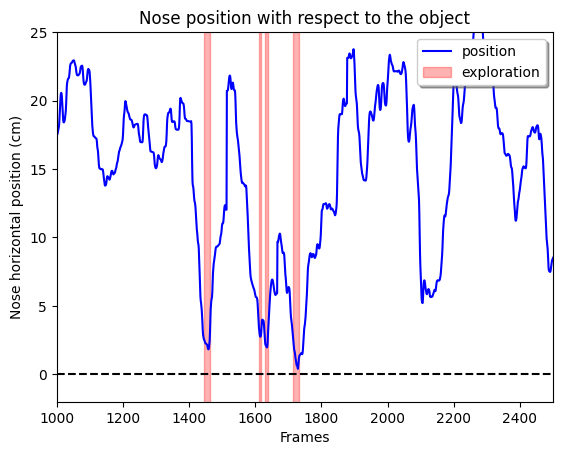

In [21]:
# Select data to plot
position = np.sqrt(X_test['nose_x']**2 + X_test['nose_y']**2).copy()
exploration = y_test.copy()

# Plotting position
plt.plot(position, label='position', color='blue')

# Shading exploration regions
plt.fill_between(range(len(exploration)), -30, 30, where = exploration > 0.5, label = 'exploration', color='red', alpha=0.3)

# Adding labels
plt.xlabel('Frames')
plt.ylabel('Nose horizontal position (cm)')
plt.legend(loc='upper right', fancybox=True, shadow=True, framealpha=1.0)
plt.title('Nose position with respect to the object')
plt.axhline(y=0, color='black', linestyle='--')

# Zoom in on some frames
plt.xlim((1000, 2500))
plt.ylim((-2, 25))

plt.show()

Lets get some tools ready for model training:

- Early stopping
- Scheduled learning rate

In [80]:
# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=patience,
    restore_best_weights=True,
    mode='min',
    verbose=1,
)

# Define a learning rate schedule function
initial_lr = lr # Set the initial lr
def lr_schedule(epoch, lr): # Define a learning rate schedule function
    initial_lr = lr  # Initial learning rate
    decay_factor = 0.9  # Learning rate decay factor
    decay_epochs = 9    # Number of epochs after which to decay the learning rate

    # Calculate the new learning rate
    lr = initial_lr * (decay_factor ** (epoch // decay_epochs))

    return lr

# Define the LearningRateScheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)

In [81]:
def plot_history(model, model_name):
    
    plt.figure(figsize=(10, 6))
    
    plt.plot(model.history['loss'], label='Training loss')
    plt.plot(model.history['val_loss'], label='Validation loss')
    plt.plot(model.history['accuracy'], label='Training accuracy')
    plt.plot(model.history['val_accuracy'], label='Validation accuracy')
    
    plt.title(f'Training of model {model_name}')
    plt.xlabel('Epochs')
    plt.ylabel('%')
    plt.legend()
    plt.show()

In [82]:
def evaluate(X, y, model):
    
    # Evaluate the model on the testing set
    y_pred = model.predict(X)
    y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions
    
    if isinstance(y, tf.Tensor):
        y = y.numpy()
    y_binary = (y > 0.5).astype(int) # Convert average labels to binary labels
    
    accuracy = accuracy_score(y_binary, y_pred_binary)
    precision = precision_score(y_binary, y_pred_binary, average = 'weighted')
    recall = recall_score(y_binary, y_pred_binary, average = 'weighted')
    f1 = f1_score(y_binary, y_pred_binary, average = 'weighted')
    
    print(classification_report(y_binary, y_pred_binary))
    
    return accuracy, precision, recall, f1

def evaluate_continuous(X, y, model):
    # Ensure X and y are on the same device
    if isinstance(X, tf.Tensor):
        if '/GPU:' in X.device:
            y = tf.convert_to_tensor(y)
            y = tf.identity(y)

    # Evaluate the model on the testing set
    y_pred = model.predict(X)

    # Convert y and y_pred to numpy arrays if they are tensors
    if isinstance(y_pred, tf.Tensor):
        y_pred = y_pred.numpy()
    
    if isinstance(y, tf.Tensor):
        y = y.numpy()
    
    mse = mean_squared_error(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    
    return mse, mae, r2

Now we train the first model

In [83]:
# Build a simple neural network
model_simple = tf.keras.Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(param_0, activation='relu'),
    Dropout(0.2),
    Dense(param_H1, activation='relu'),
    Dropout(0.2),
    Dense(param_H2, activation='relu'),
    Dropout(0.2),
    Dense(param_H3, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Compile the model
model_simple.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_lr),
                     loss='binary_crossentropy', metrics=['accuracy'])

In [84]:
model_simple.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,585 (14.00 KB)

 Trainable params: 3,585 (14.00 KB)

 Non-trainable params: 0 (0.00 B)

In [85]:
# Train the model
history_simple = model_simple.fit(X_train, y_train,
                                  epochs=epochs,
                                  batch_size=batch_size,
                                  validation_data=(X_val, y_val),
                                  callbacks=[early_stopping, lr_scheduler])

Epoch 1/100
14772/14772 ━━━━━━━━━━━━━━━━━━━━ 21s 1ms/step - accuracy: 0.8902 - loss: 0.1820 - val_accuracy: 0.9166 - val_loss: 0.1001 - learning_rate: 1.0000e-04
Epoch 2/100
14772/14772 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step - accuracy: 0.9189 - loss: 0.1142 - val_accuracy: 0.9175 - val_loss: 0.0900 - learning_rate: 1.0000e-04
Epoch 3/100
14772/14772 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - accuracy: 0.9252 - loss: 0.1021 - val_accuracy: 0.9187 - val_loss: 0.0921 - learning_rate: 1.0000e-04
Epoch 4/100
14772/14772 ━━━━━━━━━━━━━━━━━━━━ 21s 1ms/step - accuracy: 0.9262 - loss: 0.0975 - val_accuracy: 0.9193 - val_loss: 0.0905 - learning_rate: 1.0000e-04
Epoch 5/100
14772/14772 ━━━━━━━━━━━━━━━━━━━━ 27s 2ms/step - accuracy: 0.9262 - loss: 0.0940 - val_accuracy: 0.9193 - val_loss: 0.0865 - learning_rate: 1.0000e-04
Epoch 6/100
14772/14772 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step - accuracy: 0.9292 - loss: 0.0905 - val_accuracy: 0.9190 - val_loss: 0.0887 - learning_rate: 1.0000e-04
Epoch 7/100
14772/14772 ━━━━

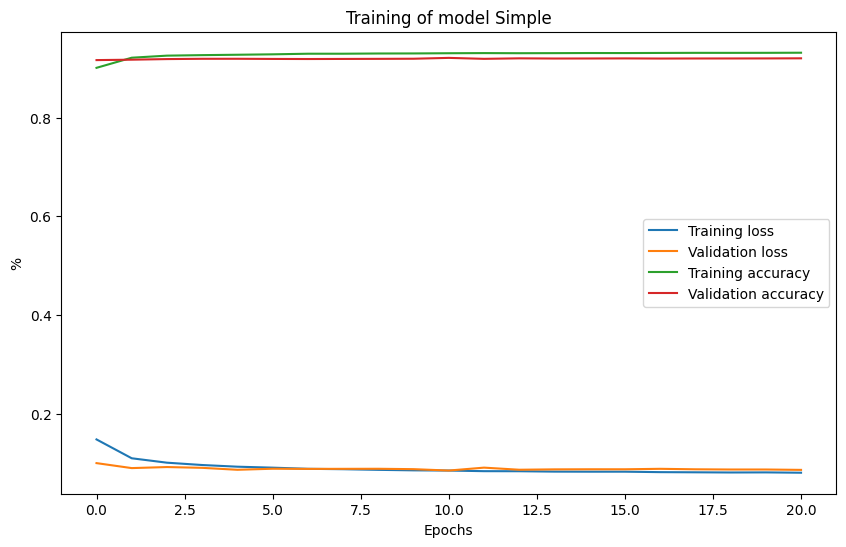

In [86]:
# Plot the training and validation loss
plot_history(history_simple, "Simple")

In [87]:
# Calculate accuracy and precision of the model
accuracy_simple, precision_simple, recall_simple, f1_simple = evaluate(X_test, y_test, model_simple)
print(f"Accuracy = {accuracy_simple:.4f}, Precision = {precision_simple:.4f}, Recall = {recall_simple:.4f}, F1 Score = {f1_simple:.4f} -> simple")

mse_simple, mae_simple, r2_simple = evaluate_continuous(X_test, y_test, model_simple)
print(f"MSE = {mse_simple:.4f}, MAE = {mae_simple:.4f}, R-squared = {r2_simple:.4f} -> simple")

782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     23561
           1       0.78      0.93      0.85      1443

    accuracy                           0.98     25004
   macro avg       0.89      0.96      0.92     25004
weighted avg       0.98      0.98      0.98     25004

Accuracy = 0.9808, Precision = 0.9831, Recall = 0.9808, F1 Score = 0.9816 -> simple
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step
MSE = 0.0083, MAE = 0.0309, R-squared = 0.8381 -> simple


In [88]:
# Save the model
model_simple.save(os.path.join(STORM_folder, f'simple/model_simple_{start_time.date()}.keras'))

Lets move onto training a Recursive Network (that can see sequences)

In [89]:
X_train_seq = np.array([df.values for df in X_train_wide])
X_val_seq = np.array([df.values for df in X_val_wide])
X_test_seq = np.array([df.values for df in X_test_wide])

In [90]:
# Define the LSTM model
model_wide = tf.keras.Sequential([
    Input(shape=(frames, X_train_seq.shape[2])),
    LSTM(param_0, return_sequences=True),
    Dropout(0.2),
    LSTM(param_H1, return_sequences=True),
    Dropout(0.2),
    LSTM(param_H2, return_sequences=True),
    Dropout(0.2),
    LSTM(param_H3),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Compile the model
model_wide.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_lr),
                     loss='binary_crossentropy', metrics=['accuracy'])

In [91]:
model_wide.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 5, 64)          │        19,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 5, 32)          │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 5, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 5, 16)          │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 5, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 8)              │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,073 (140.91 KB)

 Trainable params: 36,073 (140.91 KB)

 Non-trainable params: 0 (0.00 B)

In [92]:
# Train the model
history_wide = model_wide.fit(X_train_seq, y_train,
                              epochs = epochs,
                              batch_size = batch_size,
                              validation_data=(X_val_seq, y_val),
                              callbacks=[early_stopping, lr_scheduler])

Epoch 1/100
14772/14772 ━━━━━━━━━━━━━━━━━━━━ 68s 4ms/step - accuracy: 0.9162 - loss: 0.1786 - val_accuracy: 0.9184 - val_loss: 0.0944 - learning_rate: 1.0000e-04
Epoch 2/100
14772/14772 ━━━━━━━━━━━━━━━━━━━━ 67s 5ms/step - accuracy: 0.9299 - loss: 0.0815 - val_accuracy: 0.9198 - val_loss: 0.0924 - learning_rate: 1.0000e-04
Epoch 3/100
14772/14772 ━━━━━━━━━━━━━━━━━━━━ 68s 5ms/step - accuracy: 0.9335 - loss: 0.0738 - val_accuracy: 0.9189 - val_loss: 0.0894 - learning_rate: 1.0000e-04
Epoch 4/100
14772/14772 ━━━━━━━━━━━━━━━━━━━━ 94s 6ms/step - accuracy: 0.9327 - loss: 0.0723 - val_accuracy: 0.9203 - val_loss: 0.0903 - learning_rate: 1.0000e-04
Epoch 5/100
14772/14772 ━━━━━━━━━━━━━━━━━━━━ 106s 7ms/step - accuracy: 0.9327 - loss: 0.0708 - val_accuracy: 0.9189 - val_loss: 0.0945 - learning_rate: 1.0000e-04
Epoch 6/100
14772/14772 ━━━━━━━━━━━━━━━━━━━━ 124s 8ms/step - accuracy: 0.9328 - loss: 0.0694 - val_accuracy: 0.9201 - val_loss: 0.0898 - learning_rate: 1.0000e-04
Epoch 7/100
14772/14772 ━━

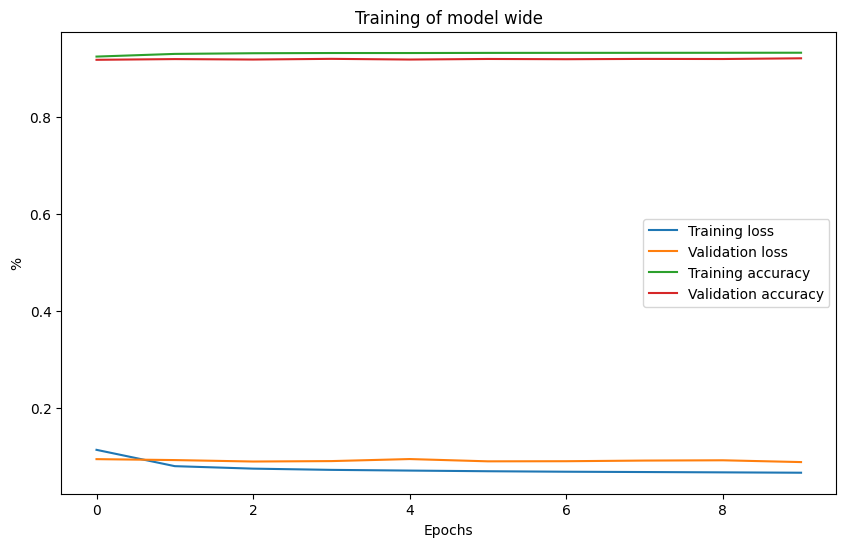

In [93]:
# Plot the training and validation loss
plot_history(history_wide, "wide")

In [94]:
# Calculate accuracy and precision of the model
accuracy_wide, precision_wide, recall_wide, f1_wide = evaluate(X_test_seq, y_test, model_wide)
print(f"Accuracy = {accuracy_wide:.4f}, Precision = {precision_wide:.4f}, Recall = {recall_wide:.4f}, F1 Score = {f1_wide:.4f} -> wide")

mse_wide, mae_wide, r2_wide = evaluate_continuous(X_test_seq, y_test, model_wide)
print(f"MSE = {mse_wide:.4f}, MAE = {mae_wide:.4f}, R-squared = {r2_wide:.4f} -> wide")

782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
              precision    recall  f1-score   support

           0       0.99      0.98      0.99     23561
           1       0.75      0.88      0.81      1443

    accuracy                           0.98     25004
   macro avg       0.87      0.93      0.90     25004
weighted avg       0.98      0.98      0.98     25004

Accuracy = 0.9762, Precision = 0.9785, Recall = 0.9762, F1 Score = 0.9770 -> wide
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
MSE = 0.0117, MAE = 0.0341, R-squared = 0.7717 -> wide


In [95]:
# Save the model
model_wide.save(os.path.join(STORM_folder, f'wide/model_wide_{start_time.date()}.keras'))

Lets also train a Random Forest model

In [96]:
# We train a RF model with the same data
if not make_discrete:
    y_train = (y_train > 0.5).astype(int)

# Create the Random Forest model (and set the number of estimators (decision trees))
RF_model = RandomForestClassifier(n_estimators = 24, max_depth = 12)

# Train the MultiOutputClassifier with your data
RF_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=12, n_estimators=24)

In [97]:
# Calculate accuracy and precision of the model
accuracy_RF, precision_RF, recall_RF, f1_RF = evaluate(X_test, y_test, RF_model)
print(f"Accuracy = {accuracy_RF:.4f}, Precision = {precision_RF:.4f}, Recall = {recall_RF:.4f}, F1 Score = {f1_RF:.4f} -> RF")

mse_RF, mae_RF, r2_RF = evaluate_continuous(X_test, y_test, RF_model)
print(f"MSE = {mse_RF:.4f}, MAE = {mae_RF:.4f}, R-squared = {r2_RF:.4f} -> RF")

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     23561
           1       0.80      0.88      0.84      1443

    accuracy                           0.98     25004
   macro avg       0.90      0.93      0.91     25004
weighted avg       0.98      0.98      0.98     25004

Accuracy = 0.9805, Precision = 0.9816, Recall = 0.9805, F1 Score = 0.9809 -> RF
MSE = 0.0165, MAE = 0.0284, R-squared = 0.6779 -> RF


In [98]:
# Save the model
joblib.dump(RF_model, os.path.join(STORM_folder, f'RF/model_RF_{start_time.date()}.pkl'))

['C:/Users/dhers/Desktop\\STORM/models\\RF/model_RF_2024-10-14.pkl']

In [99]:
# Get the end time
end_time = datetime.datetime.now()

# Calculate elapsed time
elapsed_time = end_time - start_time

In [100]:
# Print the model results
print(f"Script execution time: {elapsed_time}).")

print("Evaluate model vs testing data")

print("VS binary average")
print(f"Accuracy = {accuracy_simple:.4f}, Precision = {precision_simple:.4f}, Recall = {recall_simple:.4f}, F1 Score = {f1_simple:.4f} -> simple")
print(f"Accuracy = {accuracy_wide:.4f}, Precision = {precision_wide:.4f}, Recall = {recall_wide:.4f}, F1 Score = {f1_wide:.4f} -> wide")
print(f"Accuracy = {accuracy_RF:.4f}, Precision = {precision_RF:.4f}, Recall = {recall_RF:.4f}, F1 Score = {f1_RF:.4f} -> RF")

print("VS continuous average")
print(f"MSE = {mse_simple:.4f}, MAE = {mae_simple:.4f}, R-squared = {r2_simple:.4f} -> simple")
print(f"MSE = {mse_wide:.4f}, MAE = {mae_wide:.4f}, R-squared = {r2_wide:.4f} -> wide")
print(f"MSE = {mse_RF:.4f}, MAE = {mae_RF:.4f}, R-squared = {r2_RF:.4f} -> RF")

Script execution time: 1:22:29.687732).
Evaluate model vs testing data
VS binary average
Accuracy = 0.9808, Precision = 0.9831, Recall = 0.9808, F1 Score = 0.9816 -> simple
Accuracy = 0.9762, Precision = 0.9785, Recall = 0.9762, F1 Score = 0.9770 -> wide
Accuracy = 0.9805, Precision = 0.9816, Recall = 0.9805, F1 Score = 0.9809 -> RF
VS continuous average
MSE = 0.0083, MAE = 0.0309, R-squared = 0.8381 -> simple
MSE = 0.0117, MAE = 0.0341, R-squared = 0.7717 -> wide
MSE = 0.0165, MAE = 0.0284, R-squared = 0.6779 -> RF


In [101]:
# Lets test the accuracy of a random and zero y_test

y_zeros = y_test - y_test

y_random = y_test.sample(frac=1).reset_index(drop=True)
y_random_binary = (y_random > 0.5).astype(int)

y_binary = (y_test > 0.5).astype(int)

In [102]:
# zeros
print(classification_report(y_binary, y_zeros))

accuracy_zeros = accuracy_score(y_binary, y_zeros)
precision_zeros = precision_score(y_binary, y_zeros, average = 'weighted')
recall_zeros = recall_score(y_binary, y_zeros, average = 'weighted')
f1_zeros = f1_score(y_binary, y_zeros, average = 'weighted')
print(f"Accuracy = {accuracy_zeros:.4f}, Precision = {precision_zeros:.4f}, Recall = {recall_zeros:.4f}, F1 Score = {f1_zeros:.4f} -> zeros")

mse_zeros = mean_squared_error(y_test, y_zeros)
mae_zeros = mean_absolute_error(y_test, y_zeros)
r2_zeros = r2_score(y_test, y_zeros)
print(f"MSE = {mse_zeros:.4f}, MAE = {mae_zeros:.4f}, R-squared = {r2_zeros:.4f} -> zeros")

              precision    recall  f1-score   support

           0       0.94      1.00      0.97     23561
           1       0.00      0.00      0.00      1443

    accuracy                           0.94     25004
   macro avg       0.47      0.50      0.49     25004
weighted avg       0.89      0.94      0.91     25004

Accuracy = 0.9423, Precision = 0.8879, Recall = 0.9423, F1 Score = 0.9143 -> zeros
MSE = 0.0558, MAE = 0.0677, R-squared = -0.0894 -> zeros


c:\Users\dhers\miniconda3\envs\storm\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\dhers\miniconda3\envs\storm\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\dhers\miniconda3\envs\storm\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\U

In [103]:
# random
print(classification_report(y_binary, y_random_binary))

accuracy_random = accuracy_score(y_binary, y_random_binary)
precision_random = precision_score(y_binary, y_random_binary, average = 'weighted')
recall_random = recall_score(y_binary, y_random_binary, average = 'weighted')
f1_random = f1_score(y_binary, y_random_binary, average = 'weighted')
print(f"Accuracy = {accuracy_random:.4f}, Precision = {precision_random:.4f}, Recall = {recall_random:.4f}, F1 Score = {f1_random:.4f} -> random")

mse_random = mean_squared_error(y_test, y_random)
mae_random = mean_absolute_error(y_test, y_random)
r2_random = r2_score(y_test, y_random)
print(f"MSE = {mse_random:.4f}, MAE = {mae_random:.4f}, R-squared = {r2_random:.4f} -> random")

              precision    recall  f1-score   support

           0       0.94      0.94      0.94     23561
           1       0.06      0.06      0.06      1443

    accuracy                           0.89     25004
   macro avg       0.50      0.50      0.50     25004
weighted avg       0.89      0.89      0.89     25004

Accuracy = 0.8915, Precision = 0.8915, Recall = 0.8915, F1 Score = 0.8915 -> random
MSE = 0.1021, MAE = 0.1248, R-squared = -0.9915 -> random


In [104]:
print("Evaluate model vs testing data")

print("VS binary average")
print(f"Accuracy = {accuracy_simple:.4f}, Precision = {precision_simple:.4f}, Recall = {recall_simple:.4f}, F1 Score = {f1_simple:.4f} -> simple")
print(f"Accuracy = {accuracy_wide:.4f}, Precision = {precision_wide:.4f}, Recall = {recall_wide:.4f}, F1 Score = {f1_wide:.4f} -> wide")
print(f"Accuracy = {accuracy_RF:.4f}, Precision = {precision_RF:.4f}, Recall = {recall_RF:.4f}, F1 Score = {f1_RF:.4f} -> RF")
print(f"Accuracy = {accuracy_zeros:.4f}, Precision = {precision_zeros:.4f}, Recall = {recall_zeros:.4f}, F1 Score = {f1_zeros:.4f} -> zeros")
print(f"Accuracy = {accuracy_random:.4f}, Precision = {precision_random:.4f}, Recall = {recall_random:.4f}, F1 Score = {f1_random:.4f} -> random")

print("VS continuous average")
print(f"MSE = {mse_simple:.4f}, MAE = {mae_simple:.4f}, R-squared = {r2_simple:.4f} -> simple")
print(f"MSE = {mse_wide:.4f}, MAE = {mae_wide:.4f}, R-squared = {r2_wide:.4f} -> wide")
print(f"MSE = {mse_RF:.4f}, MAE = {mae_RF:.4f}, R-squared = {r2_RF:.4f} -> RF")
print(f"MSE = {mse_zeros:.4f}, MAE = {mae_zeros:.4f}, R-squared = {r2_zeros:.4f} -> zeros")
print(f"MSE = {mse_random:.4f}, MAE = {mae_random:.4f}, R-squared = {r2_random:.4f} -> random")

Evaluate model vs testing data
VS binary average
Accuracy = 0.9808, Precision = 0.9831, Recall = 0.9808, F1 Score = 0.9816 -> simple
Accuracy = 0.9762, Precision = 0.9785, Recall = 0.9762, F1 Score = 0.9770 -> wide
Accuracy = 0.9805, Precision = 0.9816, Recall = 0.9805, F1 Score = 0.9809 -> RF
Accuracy = 0.9423, Precision = 0.8879, Recall = 0.9423, F1 Score = 0.9143 -> zeros
Accuracy = 0.8915, Precision = 0.8915, Recall = 0.8915, F1 Score = 0.8915 -> random
VS continuous average
MSE = 0.0083, MAE = 0.0309, R-squared = 0.8381 -> simple
MSE = 0.0117, MAE = 0.0341, R-squared = 0.7717 -> wide
MSE = 0.0165, MAE = 0.0284, R-squared = 0.6779 -> RF
MSE = 0.0558, MAE = 0.0677, R-squared = -0.0894 -> zeros
MSE = 0.1021, MAE = 0.1248, R-squared = -0.9915 -> random
